In [1]:
from pandas import Series, DataFrame
import pandas as pd
%pylab inline
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


## Set up data

In [2]:
df = pd.read_csv('New_AirBnB_Austin.csv')
df = df.drop(['Unnamed: 0'],axis=1)
print df.columns.values
print df.shape # <- The dataset has 1819 rows (for Austin metro area), 11 columns (including Zipcode and title word count)

['average_rate($)' 'num_of_bedrooms' 'title_word_count' 'city'
 'date_of_listing' 'description' 'title' 'url' 'Listing Month'
 'Listing Year' 'Zipcode']
(1819, 11)


In [3]:
# There are some duplicates in the dataset - should drop duplicates on description and zip (urls can be different)
print df.iloc[49]
print df.iloc[1705]

average_rate($)                                                   260
num_of_bedrooms                                                     2
title_word_count                                                    1
city                                                           Austin
date_of_listing                                             July 2013
description         Hi.New.Lovely country-house.Perfect long/short...
title               2BRHouse/3.5Miles/F1-COTA/Short/LongTermRates/...
url                 https://www.airbnb.com/rooms/1722387?location=...
Listing Month                                                    July
Listing Year                                                     2013
Zipcode                                                       [78617]
Name: 49, dtype: object
average_rate($)                                                   260
num_of_bedrooms                                                     2
title_word_count                                                  

In [4]:
# Drop duplicate listings
df = df.drop_duplicates(subset = ['description','Zipcode'])
len(df)

1362

In [5]:
# Zipcode cleanup and converting bedroom count type
df['Zipcode'] = df['Zipcode'].str[1:-1]
df['num_of_bedrooms'] = df['num_of_bedrooms'].astype(int)
df[:2]

,average_rate($),num_of_bedrooms,title_word_count,city,date_of_listing,description,title,url,Listing Month,Listing Year,Zipcode
0,82,2,6,Austin,December 2015,"Cute two bedroom with lots of windows, sunny b...",Cosy 2 Bedroom in Hyde Park!,https://www.airbnb.com/rooms/18550276?location...,December,2015,78751
1,110,1,4,Austin,September 2015,Comfortable Traditional Interior Furniture in ...,Fabulous Central Austin Condo!,https://www.airbnb.com/rooms/13571814?location...,September,2015,78704


In [6]:
#Get word count for description
def word_count(str):
    return len(str.split())
df['description_word_count'] = df['description'].map(word_count)

columns = df.columns.tolist()
columns.insert(3, columns[len(columns)-1])
df = df[columns[:-1]]
df[:2]

,average_rate($),num_of_bedrooms,title_word_count,description_word_count,city,date_of_listing,description,title,url,Listing Month,Listing Year,Zipcode
0,82,2,6,29,Austin,December 2015,"Cute two bedroom with lots of windows, sunny b...",Cosy 2 Bedroom in Hyde Park!,https://www.airbnb.com/rooms/18550276?location...,December,2015,78751
1,110,1,4,42,Austin,September 2015,Comfortable Traditional Interior Furniture in ...,Fabulous Central Austin Condo!,https://www.airbnb.com/rooms/13571814?location...,September,2015,78704


## Summary stats for paper

In [7]:
df.describe()

,average_rate($),num_of_bedrooms,title_word_count,description_word_count,Listing Year
count,1362.000000,1362.000000,1362.000000,1362.000000,1362.000000
mean,159.265786,1.522761,5.646109,57.220264,2014.375918
std,278.880700,1.132576,1.957938,54.560376,1.820273
min,16.000000,0.000000,1.000000,1.000000,2009.000000
25%,50.000000,1.000000,4.000000,37.000000,2013.000000
50%,90.000000,1.000000,6.000000,47.000000,2015.000000
75%,150.000000,2.000000,7.000000,73.000000,2016.000000
max,4500.000000,10.000000,12.000000,902.000000,2017.000000


## Exploratory Analysis

**Outlier identification**

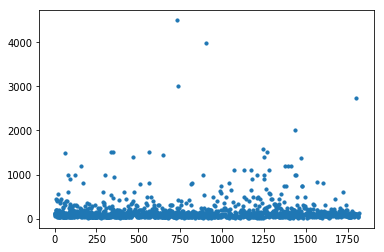

In [8]:
# Scatterplot of rates (for rate frequencies)
scatter(df.index, df['average_rate($)'], s=10)
# Three homes are at or above $3k. Quite a few are way above the population.
# Exclude anything above 2 stdev away from the mean for our analysis

1303


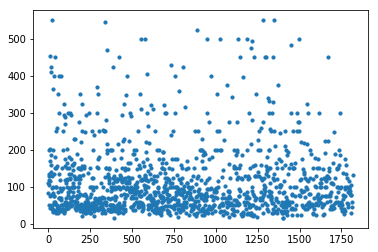

In [9]:
df2 = df[df['average_rate($)'] < 2*df.describe().iloc[2][0]] # trimmed
print len(df2) #1302 (61 got dropped)
scatter(df2.index, df2['average_rate($)'], s=10)

Text(0,0.5,'Freq Of Rate')

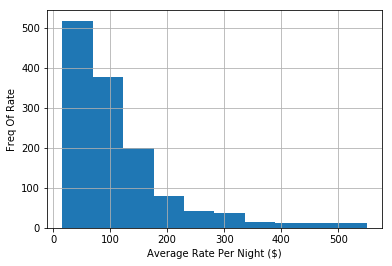

In [10]:
# Histogram of average rates, excluding those > 2 stdev
df2['average_rate($)'].hist()
xlabel('Average Rate Per Night ($)')
ylabel('Freq Of Rate')

## Trend and Seasonality Analysis

In [11]:
mask = df2['Listing Year'] != 2017

Text(0.5,1,'Listings in Austin by Year')

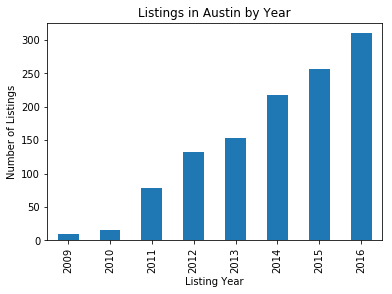

In [12]:
growth_austin = df2[mask]['Listing Year'].value_counts(ascending = True)
growth_austin.plot(kind = 'bar')
xlabel('Listing Year')
ylabel('Number of Listings')
title('Listings in Austin by Year') #We had incomplete data for 2017

In [13]:
g_factor = growth_austin.shift(-1)
growth_percent = ((g_factor - growth_austin)/growth_austin*100).shift(1).dropna()
dfGrowth = DataFrame(growth_percent)
dfGrowth['Year'] = dfGrowth.index.values

Text(0.5,1,'Annual Listing Growth in Austin')

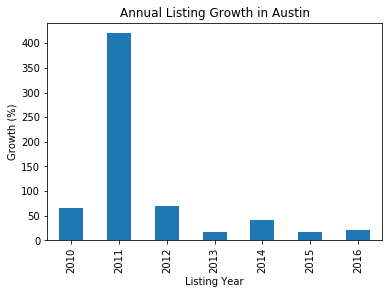

In [14]:
dfGrowth['Listing Year'].plot(kind = 'bar')
xlabel('Listing Year')
ylabel('Growth (%)')
title('Annual Listing Growth in Austin')

Text(0.5,1,'Total Listings in Austin by Month')

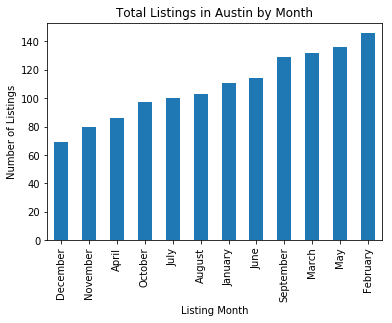

In [15]:
# Monthly listing difference
seasonal_listing = df2['Listing Month'].value_counts(ascending = True)
seasonal_listing.plot(kind = 'bar')
xlabel('Listing Month')
ylabel('Number of Listings')
title('Total Listings in Austin by Month') # more postings in the beginning of the year

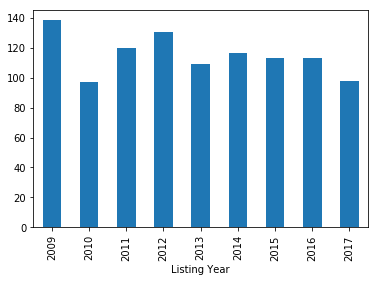

In [16]:
# Price increase (may not be representative as prices could change)
growth_price = df2.groupby('Listing Year')['average_rate($)'].mean()
growth_price.plot(kind ='bar')

## Neighborhood Analysis

In [17]:
# Listing price and count by zip
zip_rate = df2.groupby(['Zipcode'])['average_rate($)'].agg(['count','mean'])
# zip_rate.sort_values(by='mean',ascending=False)
zip_rate.sort_values(by='count', ascending = False) # There are some zipcodes with only 1 or 2 listings
# 1's below: Dripping Springs, Sun City, Hutto | 2/3/5: Liberty Hill (clsoe to Georgetown), Jollyville, east East Austin
# Look at only zipcodes with > 30 listings

,count,mean
Zipcode,,
78704,103,120.135922
78702,102,131.519608
78745,72,121.208333
78613,58,103.965517
78748,58,77.086207
78660,57,89.789474
78640,52,127.634615
78610,41,146.170732
78705,41,75.878049


In [18]:
print (len(zip_rate)) #54 zip codes total
# sort_values(by='count',ascending=False)
mask = zip_rate['count'] >= 30
print (len(zip_rate[mask]))

54
17


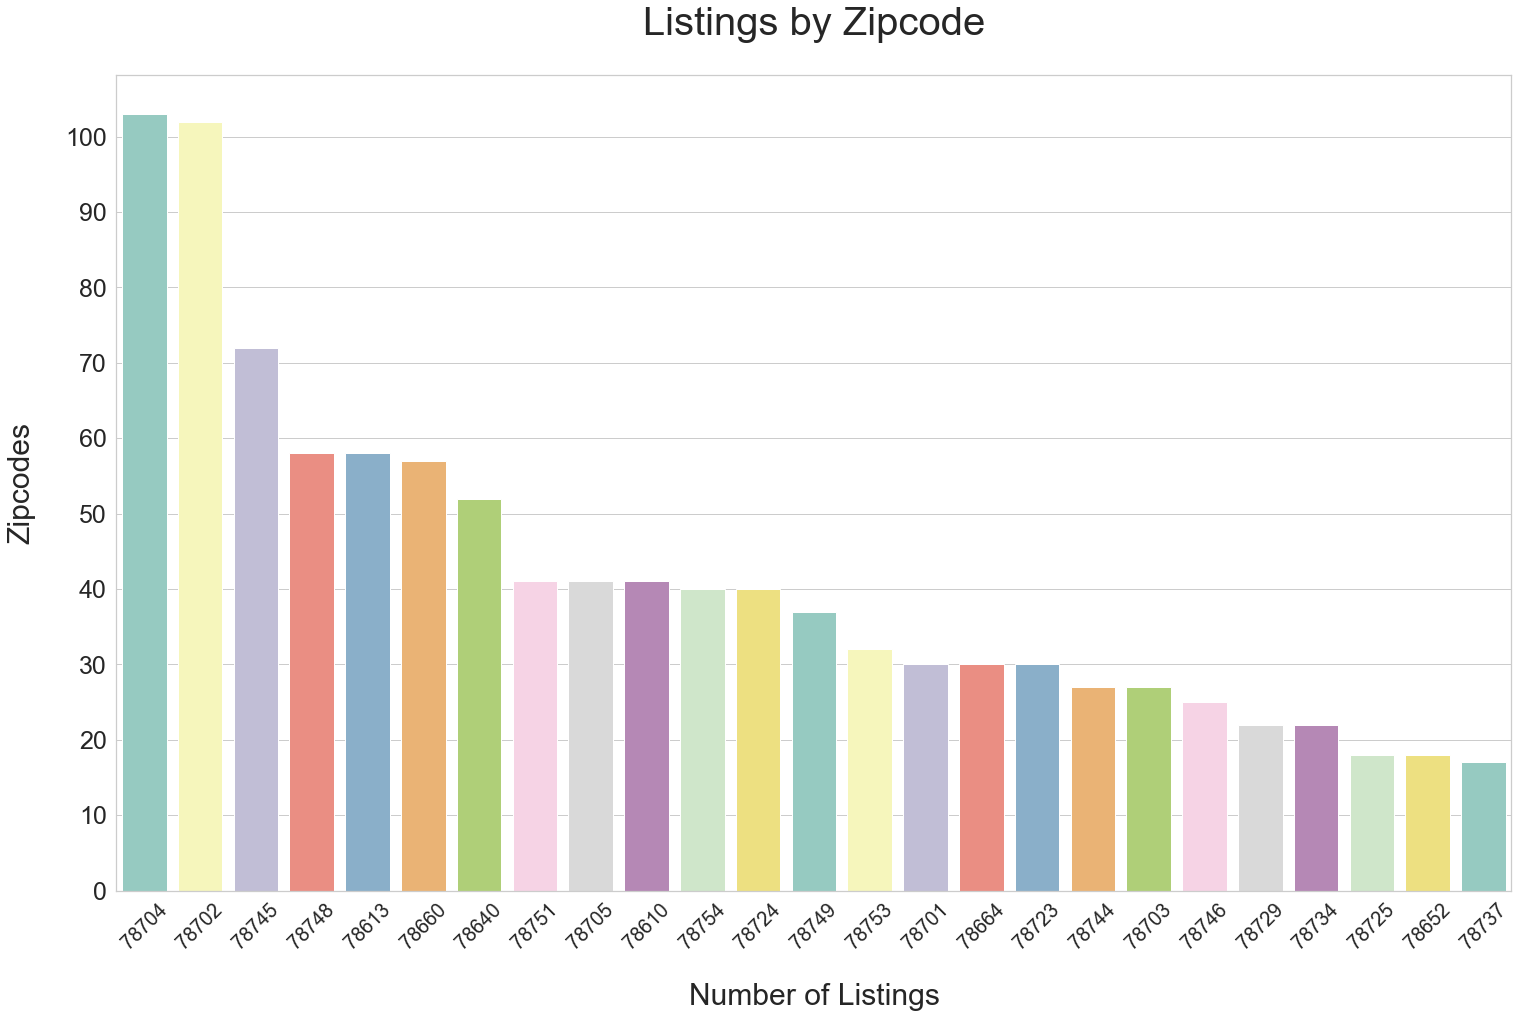

In [19]:
import matplotlib.ticker as ticker
sns.set(style="whitegrid")
fig, ax = plt.subplots()
fig.set_size_inches(25, 15)
ax.axes.set_title("Listings by Zipcode",fontsize=40,pad=40)
ax = sns.countplot(x='Zipcode',data=df2, order = df2['Zipcode'].value_counts().iloc[:25].index, palette="Set3")
ax.set_xlabel('Number of Listings',fontsize=30,labelpad=30)
ax.set_ylabel('Zipcodes',fontsize=30,labelpad=30)
ax.xaxis.set_tick_params(labelsize=20, rotation = 45)
ax.yaxis.set_tick_params(labelsize=25)
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())

In [20]:
# Price by zipcode
df_avg_price = DataFrame(df2.groupby(['Zipcode'])['average_rate($)'].mean().reset_index())
# df_avg_price['Zipcode'] = df_avg_price['Zipcode'].astype(str)
top = df2['Zipcode'].value_counts().iloc[:17].index.tolist()
top_price = df_avg_price[df_avg_price['Zipcode'].isin(top)].sort_values('average_rate($)',ascending=False)[:17].reset_index()

# Kelly help - make it descending; or we could use barplot in base Python

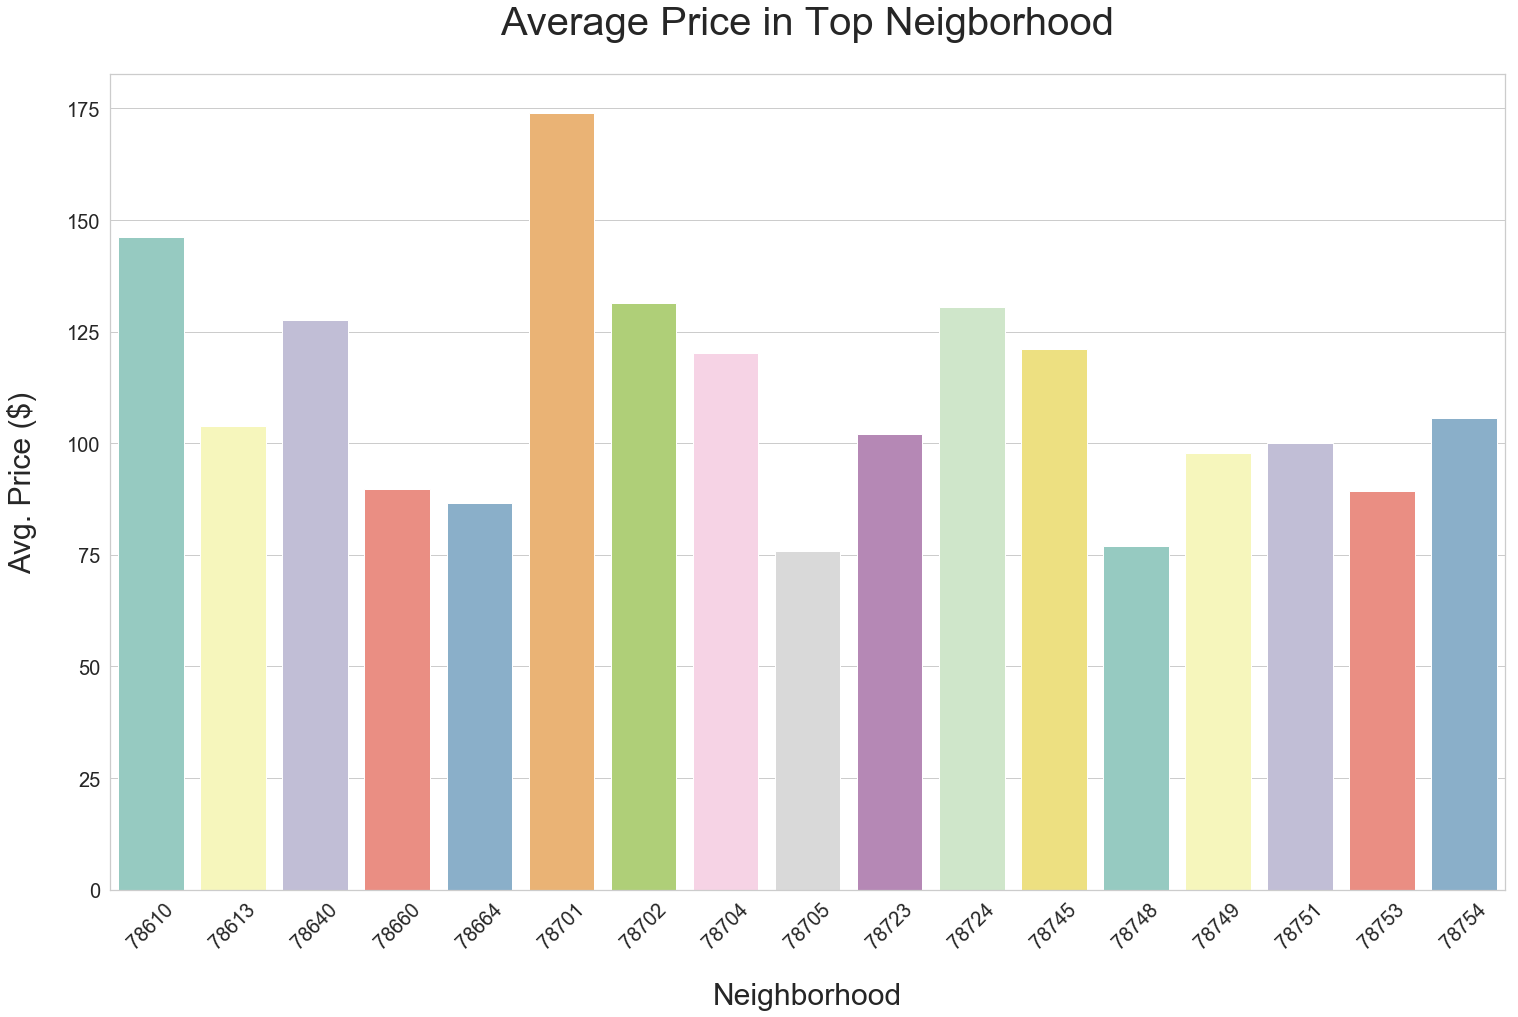

In [21]:
fig, ax = plt.subplots()
fig.set_size_inches(25, 15)
  
ax.axes.set_title("Average Price in Top Neigborhood",fontsize=40, pad=40)
ax = sns.barplot(y='average_rate($)',x ='Zipcode',
                 data = top_price,
                 palette='Set3')
ax.set_xlabel('Neighborhood',fontsize=30,labelpad=30)
ax.set_ylabel('Avg. Price ($)',fontsize=30,labelpad=30)
ax.xaxis.set_tick_params(labelsize=20, rotation = 45)
ax.yaxis.set_tick_params(labelsize=20)

Working on  78749
(37, 2)


IOError: [Errno 2] No such file or directory: 'Rate_and_RmCount_Histograms/78749.jpeg'

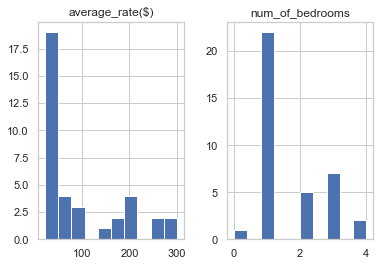

In [22]:
# Histograms of room rates and room numbers by zipcode
import os

def ziptojpeg (inputzip, df, outputpath):
    """
    ziptojpeg takes a zipcode and plots two histograms, one for average rates and another for the number of bedrooms
    Args: 
        inputzip (str): your desired zipcode
        df (dataframe): the dataframe from which to extract data from
        outputpath (str): the path to which to write the write
    Returns:
        writes to a jpeg file
    """
    # Pull the correct data from df
    result = df[df['Zipcode'] == inputzip][['average_rate($)', 'num_of_bedrooms']]
    print result.shape
    # Write the result to a file
    result.hist()
    outputfile = os.path.join(outputpath, inputzip + ".jpeg")
    plt.savefig(outputfile)

for zipcode in set(df["Zipcode"]):
    print "Working on ", zipcode
    ziptojpeg(inputzip=zipcode, df=df2, outputpath='Rate_and_RmCount_Histograms')

In [ ]:
df[:2]

## Word Count Analysis - Not Really Useful

In [ ]:
# Title word count on price; can include this in a regression model
titlecount_rate = df2.groupby('title_word_count')['average_rate($)'].agg(['count','mean'])
titlecount_rate

In [ ]:
# description word count on price
descriptioncount_rate = df2.groupby('description_word_count')['average_rate($)'].agg(['count','mean'])
descriptioncount_rate.sort_values(by='mean',ascending=False)

# Text Analysis on Description

In [ ]:
# Steps: split on description, stop words, count words, find top 10 words, then find in descriptions
# import stop words
import nltk
nltk.download('stopwords')
# Stop words... this is not really used
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

In [ ]:
# split description
import re
def words_from_description(description):
    """
    words_from_description splits words from the given string into a list of words
    args:
        description (string): one string object that user would like to split into words
    returns:
        a list of words
    """
    prelimsplitwords = re.split('\W+', description.lower()) #splits by anything that's not [a_zA_Z0-9_] and removes punctuations
    splitwords = [word for word in prelimsplitwords if word not in stop_words and word != ""] #stop words and remove empty string
    # Do we need to deal with \n? doesn't seem like it...
    return splitwords

print words_from_description("*Not an actual Treehouse\n\nWelcome to my spacious 1 bedroom apartment located on the 2nd floor. Huge windows, a working fireplace, laminate hardwood floors, wifi, and a comfortable queen size bed are just a few perks this great space offers. I offer a self check-in so you are welcome to arrive anytime after the check-in time that's convenient for you.") # sample execution

In [ ]:
# create a dictionary with descriptions and split words
import collections
description_dict = {}
# go through all quotes, key:dictionary{word:counter}
for description in df2['description']: 
    description_dict[description] = {}
    word = words_from_description(description)
    word_count = collections.Counter(word)
    description_dict[description] = word_count

In [ ]:
# Create a dictionary of description dict's words for counts
word_count_dict = {}
for key in description_dict: 
    words = words_from_description(key)
    for word in words:
        if word not in word_count_dict:
            word_count_dict[word] = 0

# THIS ONE TAKES >= 5MIN!

In [ ]:
#update the dictionary set up above with word count
for key in word_count_dict: 
    for sentence_key in description_dict:
        words = words_from_description(sentence_key)
        if key in words:
            matches = [i for i in words if i == key] 
            word_count_dict[key] += len(matches)

In [ ]:
len(word_count_dict)

In [ ]:
word_count_dict # Still need to get rid of \n... why? didn't seem to be a problem in split words

In [ ]:
sorted_word_count = sorted(word_count_dict.items(), key=lambda x: x[1], reverse = True)
sorted_word_count[70:100]

# Next steps:
1. Manually take out words to use as our extra columns (15): Austin, DT, home, private, place, room, bed, minutes, house, close, neighborhood, bedroom, 

2. We need to exclude outliers (> 2 stdev away) and exclude zipcodes with < 30 listings (15 zipcodes) before modeling
3. Convert Zipcodes and key words as categorical variables - binning adjacent zipcodes
4. Models: regression, tree, and possibly KNN

In [ ]:
# From top 20
top_key_words = ['kitchen', 'downtown', 'home', 'private', 'place', 
             'room', 'bed', 'minutes', 'house', 'close', 
             'neighborhood','bedroom', 'quiet', 'restaurants',]
# "medium-used" (still > 100) interesting key words
interesting_key_words = ['pool', 'airport', 'love', 'coffee', 'couples',
                        'business','walk','comfortable', 'modern']

In [ ]:
# Special packages
import statsmodels.api as sm
from patsy import dmatrices
df2 = df2.rename(columns={'average_rate($)':'rate'})
zip_rate = df2.groupby(['Zipcode'])['rate'].agg(['count','mean'])
mask = zip_rate['count'] >= 30
zip_rate_mskd = zip_rate[mask]
zip_rate_mskd =zip_rate_mskd.reset_index()
mask = (df2['Zipcode'].isin(zip_rate_mskd['Zipcode']))
df2 = df2[mask]

df3 = pd.get_dummies(df2,columns=['Zipcode'])
df3.shape

df3 = df3.reset_index()
df3 = df3.drop('index',axis=1)

In [ ]:
#Convert key words into separate, binary columns 0~1

# From top 20
top_key_words = ['kitchen', 'downtown', 'home', 'private', 'place',
            'room', 'bed', 'minutes', 'house', 'close',
            'neighborhood','bedroom', 'quiet', 'restaurants',]
# "medium-used" (still > 100) interesting key words
interesting_key_words = ['pool', 'airport', 'love', 'coffee', 'couples',
                       'business','walk','comfortable', 'modern']


for word in top_key_words:
    for i in range(df3.shape[0]):
            if word in df3['description'][i]:
                df3[word]= 1
            else:
                df3[word]=0

for word in interesting_key_words:
    for j in range(df3.shape[0]):
        if word in df3['description'][j]:
            df3[word]=1
        else:
            df3[word]=0

In [ ]:
df3 = df3.drop(['city','date_of_listing','description','Listing Month','Listing Year','title','url'],axis=1)
df3.columns.values


In [ ]:
#Multi-Regression Modeling
all_column_names = df3.columns.values[1:]

formula = 'rate ~ {}'.format(' + '.join(['Q("{}")'.format(x) for x in all_column_names]))

y, X = dmatrices(formula,df3,return_type='dataframe')
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

model_train = sm.OLS(y_train, X_train)
result_train = model_train.fit()
print result_train.summary()

In [ ]:
from sklearn.linear_model import LinearRegression
model2_train = LinearRegression().fit(X_train,y_train)
predict_results = model2_train.predict(X_test)

y_test_values = y_test['rate'].values.astype(int)

MSE = (predict_results-y_test_values)

for i in range(len(MSE)):
    MSE[i]= MSE[i]**2
    

total = mean(MSE)
RMSE = sqrt(total)


print 'The RMSE of our model is',RMSE, 'oh god..'
    